In [1]:
import xarray as xr
import os
import pandas as pd

In [2]:
path = '/work/mech-ai-scratch/rtali/AI_READY_IOWA/'
sub_folder = 'IN4326'



In [ ]:
cdl = xr.load_dataset(os.path.join(path,'CDL',sub_folder,'2023_WGS84.nc'))

KeyboardInterrupt: 

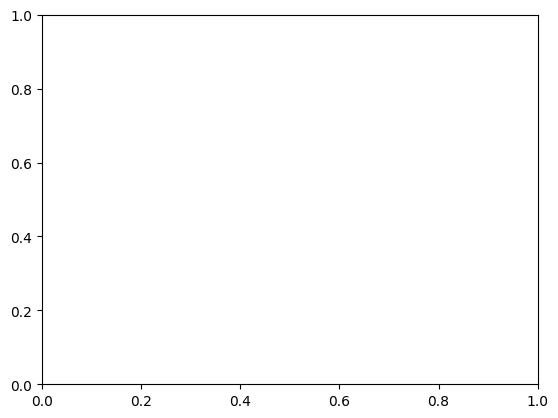

In [10]:
cdl.__xarray_dataarray_variable__.plot()

In [ ]:
clss = cdl['__xarray_dataarray_variable__']

In [ ]:
df = clss.to_dataframe()
df

In [ ]:
df.__xarray_dataarray_variable__.value_counts()

In [ ]:
soil = xr.load_dataset(os.path.join(path,'SOIL','IA.nc'))
# weather = xr.load_dataset(os.path.join(path,'WEATHER',sub_folder,'merged_daymet_2023.nc'))

In [4]:
soil

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 5979, y: 3326)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 48kB -96.79 -96.79 -96.78 ... -88.53 -88.53 -88.53
  * y            (y) float64 27kB 44.59 44.59 44.59 44.58 ... 40.0 40.0 40.0
Data variables:
    spatial_ref  int64 8B 0
    nccpi3all    (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    nccpi3corn   (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    nccpi3soy    (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    rootznaws    (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    soc150       (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    soc999       (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan
    pctearthmc   (y, x) float64 159MB nan nan nan nan nan ... nan nan nan nan

In [ ]:
soil.variables

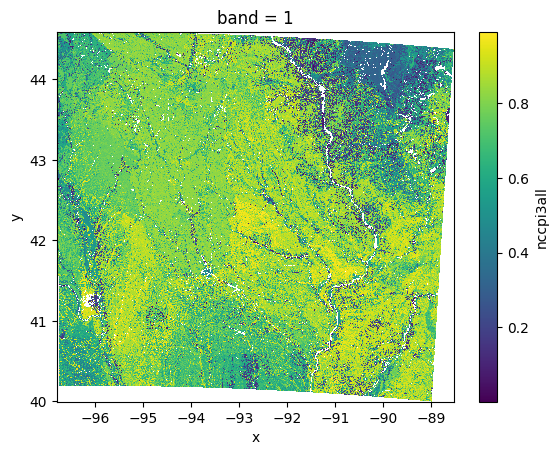

In [6]:
soil.nccpi3all.plot()

In [7]:
weather = xr.load_dataset(os.path.join(path,'WEATHER','IA_2023.nc'))

In [9]:
weather

<xarray.Dataset> Size: 2GB
Dimensions:                  (x: 625, y: 339, time: 365)
Coordinates:
  * x                        (x) float64 5kB -96.8 -96.78 ... -89.64 -89.63
  * y                        (y) float64 3kB 43.87 43.85 43.84 ... 40.0 39.99
  * time                     (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
    lambert_conformal_conic  int64 8B 0
Data variables:
    dayl                     (time, y, x) float32 309MB nan nan nan ... nan nan
    lat                      (y, x) float64 2MB nan nan nan nan ... nan nan nan
    lon                      (y, x) float64 2MB nan nan nan nan ... nan nan nan
    prcp                     (time, y, x) float32 309MB nan nan nan ... nan nan
    srad                     (time, y, x) float32 309MB nan nan nan ... nan nan
    swe                      (time, y, x) float32 309MB nan nan nan ... nan nan
    tmax                     (time, y, x) float32 309MB nan nan nan ... nan nan
    tmin                     (time, y, x) float32 309MB nan nan nan ... nan nan
    vp                       (time, y, x) float32 309MB nan nan nan ... nan nan
Attributes:
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    start_year:          2023
    source:              Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Version_software:    Daymet Software Version 4.0
    Conventions:         CF-1.6
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  39.97591721881702
    geospatial_lat_max:  43.880950040858615
    geospatial_lon_min:  -96.81426396587968
    geospatial_lon_max:  -89.6280561958434

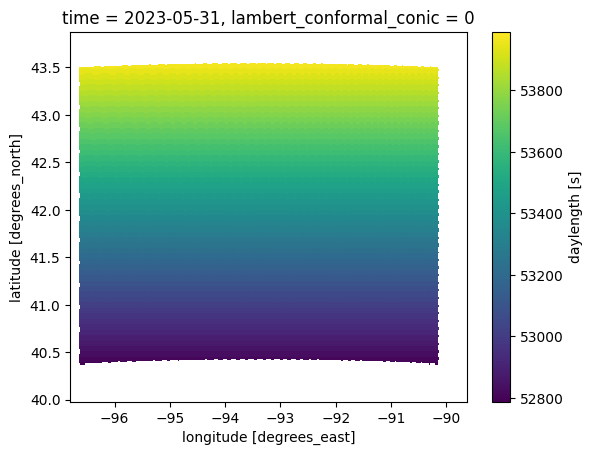

In [8]:
weather.isel(time=150).dayl.plot()